# Notebook for multiple sessions

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score

In [2]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models

# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [3]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [4]:
n_sessions = len(data)

In [5]:
#@title Representative session
#@markdown Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["MOp", "MOs"],
                  ]
regions = ["visual", "motor"]

def count_neurons_per_brain_area():
    neurons_in_session = []
    for i in range (0,n_sessions):
        session = data[i]
        brain_areas = session['brain_area']

        neurons_in_area = []
        for group in brain_groups:
            count = 0
            for area in group:
                count += np.count_nonzero(brain_areas == area)
            neurons_in_area.append(count)
        neurons_in_session.append(neurons_in_area)
    return neurons_in_session

def plot_areas_sessions(sessions, neurons_in_session):
    fig, ax = plt.subplots(figsize=(18, 5))
    neurons_in_session = np.asarray(neurons_in_session).T
    im = ax.imshow(neurons_in_session)
    ax.set_xticks(np.arange(len(sessions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_yticklabels(regions)
    ax.set_xticklabels(sessions)
    
    for i in range(len(regions)):
        for j in range(len(sessions)):
            text = ax.text(j, i, str(neurons_in_session[i,j]),
                           ha="center", va="center", color="w")
    ax.set_title("Number of neurons per brain area")
    fig.tight_layout()
    plt.show()
    
    
def get_representative_sessions(min_visual=1, min_motor=1):
    representative_sessions = []
    new_neurons = []
    neurons_in_session = count_neurons_per_brain_area()
    
    for session, n_neurons in enumerate(neurons_in_session):
        if(n_neurons[0] > min_visual and n_neurons[1] > min_motor):
            representative_sessions.append(session)
            new_neurons.append(n_neurons)
    plot_areas_sessions(representative_sessions, new_neurons)
    
    return representative_sessions


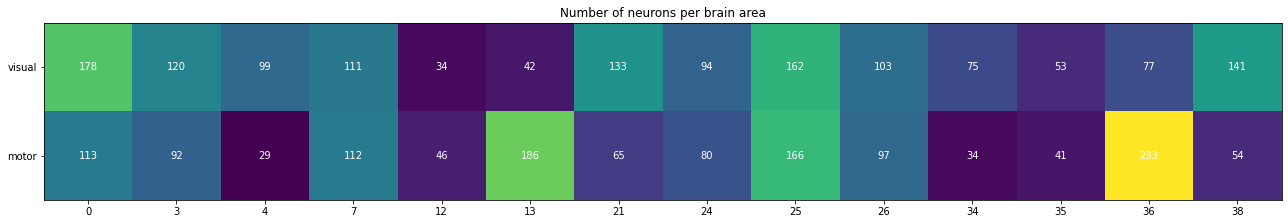

In [6]:
idx_session  = get_representative_sessions(20, 20)
# Get subset of selected sessions:
data = data[idx_session]

In [7]:
# DEFAULTS
N_XVAL = 10 # cross validation
ANALYSIS_TIME_WINDOW =  np.array([0,0.5]) # time window to analize
DOWNSAMPLING_FACTOR  = 'all'  # 'all'-> implies that the analisis time window is compressed to 1
TRIAL_RANGE = np.array([-0.5, 2])
SAMP_RATE = 0.01


N_SESSIONS = len(data)
EXCLUDE_PRE = abs(ANALYSIS_TIME_WINDOW[0]-TRIAL_RANGE[0])
EXCLUDE_POST  = abs(ANALYSIS_TIME_WINDOW[1]-TRIAL_RANGE[1])


In [8]:
print(N_SESSIONS)

14


In [12]:

def stim_to_a1(session_data, region="visual"):
    # Get data
    region_dat = utils.get_region_data(session_data, region=region, data_type='fr')
    stim = session_data['stims']
    n_region_neurons = region_dat.shape[0]
    n_analysis_time_bins = region_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region_dat = region_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        # Model Linear Regression
        encoder, enc_coefs, enc_model = models.train_linear_encoder(stim, region_dat)
        A1 = enc_coefs
        region_dat_hat = encoder(stim)
    
        enc_perf = np.zeros((n_region_neurons,N_XVAL))
        for neuron in range(n_region_neurons):
            # PARA ANALIZAR LA IMPORTANCIA DE CADA NEURONA
            enc_perf[neuron] = cross_val_score(enc_model, stim, region_dat[:,neuron], cv=N_XVAL, scoring='explained_variance')
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    return A1, enc_perf


#ToDo: define if we neeed this function    
def performance_per_neuron(neurons, neurons_hat, enc_perf):
    #MSE and R2 per unit
    encoding_scores = pd.DataFrame(columns = ['r2', 'xval_r2', 'mse', 'nrmse'])
    encoding_scores['r2'] = metrics.r2(neurons.T,neurons_hat.T)
    encoding_scores['mse'] = metrics.mse(neurons.T,neurons_hat.T)
    encoding_scores['nrmse'] = metrics.nrmse(neurons.T,neurons_hat.T)
    encoding_scores['xval_r2'] = np.median(enc_perf,axis=1)

    return encoding_scores.mean()

In [ ]:
def 

In [13]:

data_set = [None] * N_SESSIONS
A1={i:[] for i in range(N_SESSIONS)}
encoding_perf={i:[] for i in range(N_SESSIONS)}

for session in range(N_SESSIONS):
    data_set[session] = utils.filter_no_go_choice(data[session])
    data_set[session]['fr'] = utils.spikes_to_fr(data_set[session]['spks'], 
                                    samp_rate=SAMP_RATE, 
                                    downsampling_factor=DOWNSAMPLING_FACTOR, 
                                    exclude_pre=EXCLUDE_PRE, 
                                    exclude_post=EXCLUDE_POST,
                                   )
    train_set, val_set = utils.split_validation_set(data_set[session])    
    A1[session], encoding_perf[session] = stim_to_a1(train_set, "visual")
    


In [29]:
 #Variance
variance = [encoding_perf[session].mean() for session in range(N_SESSIONS)]

print(np.mean(variance))

-0.06373095649278113
